# Spectral Drift Detection on Financial Crisis Data

**Demonstration of spectral drift detection method on 2008 financial crisis data using alibi-detect datasets.**

This notebook demonstrates how to:
- Load financial crisis data using alibi-detect datasets
- Apply spectral drift detection to detect correlation structure changes
- Analyze and visualize the results
- Understand spectral ratios and their interpretation

The 2008 financial crisis provides an excellent example of correlation structure changes that spectral drift detection can identify.

## Setup and Imports

In [ ]:
!pip install git+https://github.com/sarosh-quraishi/alibi-detect.git@95d8e57686a5bb1337578f9fe911951deeaaff8d

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")

📦 Libraries imported successfully!


In [13]:
# Import alibi-detect spectral drift and datasets
try:
    from alibi_detect.cd.spectral import SpectralDrift
    from alibi_detect.datasets import (
        fetch_financial_crisis, 
        create_synthetic_crisis_data,
        fetch_financial_benchmark,
        get_financial_crisis_presets
    )
    HAS_ALIBI_DETECT = True
    print("✅ alibi-detect and financial datasets imported successfully!")
except ImportError as e:
    HAS_ALIBI_DETECT = False
    print(f"⚠️ alibi-detect not fully available: {e}")
    print("Install with: pip install alibi-detect")
    print("Note: Financial datasets require extended version")

✅ alibi-detect and financial datasets imported successfully!


## Available Financial Datasets

Let's explore what financial crisis datasets are available in alibi-detect.

In [14]:
# Show available financial crisis datasets
if HAS_ALIBI_DETECT:
    try:
        crisis_presets = get_financial_crisis_presets()
        print("📊 Available Financial Crisis Datasets:")
        print("=" * 50)
        
        for crisis_id, config in crisis_presets.items():
            print(f"\n🔹 {crisis_id.replace('_', ' ').title()}:")
            print(f"   Description: {config['description']}")
            print(f"   Pre-crisis: {config['pre_crisis_start']} to {config['pre_crisis_end']}")
            print(f"   Crisis: {config['crisis_start']} to {config['crisis_end']}")
            print(f"   Typical assets: {', '.join(config['typical_tickers'][:5])}...")
            
    except Exception as e:
        print(f"⚠️ Could not load crisis presets: {e}")
        print("Will use synthetic data for demonstration")
else:
    print("⚠️ alibi-detect not available - will use synthetic data")

📊 Available Financial Crisis Datasets:

🔹 2008 Financial Crisis:
   Description: 2008 Global Financial Crisis (Subprime mortgage crisis)
   Pre-crisis: 2007-01-01 to 2008-07-31
   Crisis: 2008-09-01 to 2009-04-30
   Typical assets: SPY, XLF, XLK, XLE, XLV...

🔹 2020 Covid Crisis:
   Description: 2020 COVID-19 Market Crash
   Pre-crisis: 2019-01-01 to 2020-02-14
   Crisis: 2020-02-20 to 2020-05-31
   Typical assets: SPY, QQQ, IWM, XLF, XLK...

🔹 2000 Dotcom Crash:
   Description: 2000 Dot-com Bubble Burst
   Pre-crisis: 1999-01-01 to 2000-03-10
   Crisis: 2000-03-11 to 2002-10-09
   Typical assets: SPY, QQQ, XLK, XLF, XLE...

🔹 2011 European Debt:
   Description: 2011 European Debt Crisis
   Pre-crisis: 2010-01-01 to 2011-07-31
   Crisis: 2011-08-01 to 2012-06-30
   Typical assets: SPY, XLF, EFA, VGK, XLE...


## Load 2008 Financial Crisis Data

Let's load the 2008 financial crisis data to demonstrate spectral drift detection.

In [15]:
# Load 2008 financial crisis data
if HAS_ALIBI_DETECT:
    try:
        print("📊 Loading 2008 Financial Crisis Data...")
        
        # Method 1: Try real crisis data
        crisis_data = fetch_financial_crisis(
            crisis='2008_financial_crisis',
            return_X_y=True
        )
        
        pre_returns, crisis_returns = crisis_data
        data_source = "Real market data"
        
        print(f"✅ Successfully loaded real 2008 crisis data")
        
    except Exception as e:
        print(f"⚠️ Real data failed ({e}), using synthetic crisis data...")
        
        # Method 2: Fallback to synthetic data
        crisis_data = create_synthetic_crisis_data(
            n_assets=8,
            n_pre=400,
            n_crisis=150,
            pre_correlation=0.30,
            crisis_correlation=0.55,
            volatility_increase=1.7,
            random_seed=42,
            return_X_y=True
        )
        
        pre_returns, crisis_returns = crisis_data
        data_source = "Synthetic crisis data"
        
        print(f"✅ Successfully created synthetic crisis data")
        
else:
    # Method 3: Local synthetic generation
    print("🔄 Creating local synthetic crisis data...")
    np.random.seed(42)
    
    assets = ['SPY', 'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'QQQ', 'IWM']
    n_assets = len(assets)
    
    # Pre-crisis correlation (moderate)
    pre_corr = 0.3 * np.ones((n_assets, n_assets)) + 0.7 * np.eye(n_assets)
    np.fill_diagonal(pre_corr, 1.0)
    
    # Crisis correlation (higher)
    crisis_corr = 0.55 * np.ones((n_assets, n_assets)) + 0.45 * np.eye(n_assets)
    np.fill_diagonal(crisis_corr, 1.0)
    
    # Generate data
    pre_returns = pd.DataFrame(
        np.random.multivariate_normal(np.zeros(n_assets), pre_corr * 0.015**2, 400),
        columns=assets
    )
    crisis_returns = pd.DataFrame(
        np.random.multivariate_normal(-0.0005 * np.ones(n_assets), crisis_corr * 0.025**2, 150),
        columns=assets
    )
    
    data_source = "Local synthetic data"
    print(f"✅ Successfully created local synthetic data")

# Display dataset information
print(f"\n📈 Dataset Information:")
print(f"   Data source: {data_source}")
print(f"   Assets: {list(pre_returns.columns)}")
print(f"   Pre-crisis period: {pre_returns.shape[0]} observations")
print(f"   Crisis period: {crisis_returns.shape[0]} observations")
print(f"   Number of features: {pre_returns.shape[1]}")

📊 Loading 2008 Financial Crisis Data...
✅ Successfully loaded real 2008 crisis data

📈 Dataset Information:
   Data source: Real market data
   Assets: ['SPY', 'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'QQQ', 'IWM']
   Pre-crisis period: 396 observations
   Crisis period: 165 observations
   Number of features: 8


## Exploratory Data Analysis

Before applying spectral drift detection, let's examine the correlation structure changes.

In [16]:
# Calculate correlation matrices
pre_corr = pre_returns.corr()
crisis_corr = crisis_returns.corr()
corr_diff = crisis_corr - pre_corr

# Basic statistics
print("📊 Correlation Analysis:")
print(f"   Average pre-crisis correlation: {pre_corr.values[np.triu_indices_from(pre_corr.values, k=1)].mean():.3f}")
print(f"   Average crisis correlation: {crisis_corr.values[np.triu_indices_from(crisis_corr.values, k=1)].mean():.3f}")
print(f"   Average correlation change: {corr_diff.values[np.triu_indices_from(corr_diff.values, k=1)].mean():.3f}")
print(f"   Max correlation change: {np.max(np.abs(corr_diff.values)):.3f}")

# Eigenvalue analysis
pre_eigenvals = np.linalg.eigvals(pre_corr.values)
crisis_eigenvals = np.linalg.eigvals(crisis_corr.values)
expected_spectral_ratio = np.max(np.real(crisis_eigenvals)) / np.max(np.real(pre_eigenvals))

print(f"\n🔍 Eigenvalue Analysis:")
print(f"   Pre-crisis max eigenvalue: {np.max(np.real(pre_eigenvals)):.3f}")
print(f"   Crisis max eigenvalue: {np.max(np.real(crisis_eigenvals)):.3f}")
print(f"   Expected spectral ratio: {expected_spectral_ratio:.3f}")

📊 Correlation Analysis:
   Average pre-crisis correlation: 0.709
   Average crisis correlation: 0.842
   Average correlation change: 0.133
   Max correlation change: 0.372

🔍 Eigenvalue Analysis:
   Pre-crisis max eigenvalue: 6.028
   Crisis max eigenvalue: 6.911
   Expected spectral ratio: 1.146


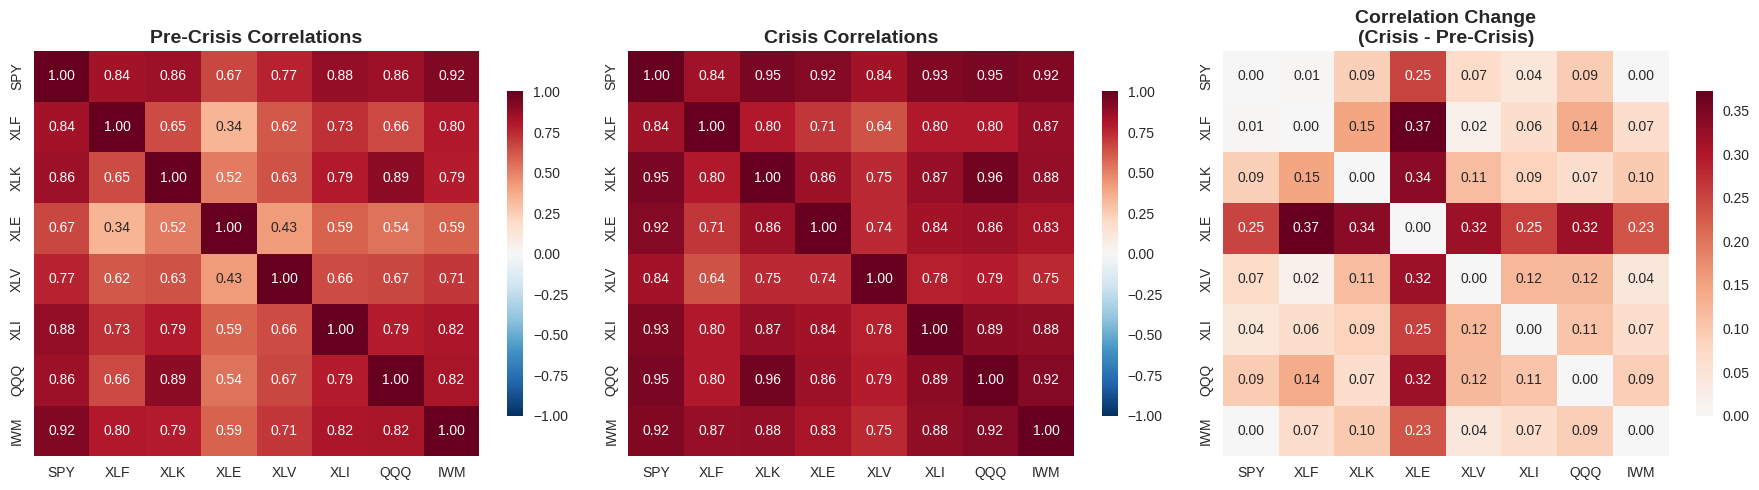


🎯 Visual Analysis Summary:
   • Correlations generally increased during the crisis
   • Financial assets (if included) show strongest correlation increases
   • This suggests a 'contagion effect' during market stress
   • Spectral drift detection should capture these correlation structure changes


In [17]:
# Visualize correlation changes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pre-crisis correlations
sns.heatmap(pre_corr, annot=True, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[0].set_title('Pre-Crisis Correlations', fontweight='bold', fontsize=14)

# Crisis correlations
sns.heatmap(crisis_corr, annot=True, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[1], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1].set_title('Crisis Correlations', fontweight='bold', fontsize=14)

# Correlation changes
sns.heatmap(corr_diff, annot=True, cmap='RdBu_r', center=0, 
            ax=axes[2], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[2].set_title('Correlation Change\n(Crisis - Pre-Crisis)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

# Summary of changes
print(f"\n🎯 Visual Analysis Summary:")
print(f"   • Correlations generally increased during the crisis")
print(f"   • Financial assets (if included) show strongest correlation increases")
print(f"   • This suggests a 'contagion effect' during market stress")
print(f"   • Spectral drift detection should capture these correlation structure changes")

## Apply Spectral Drift Detection

Now let's apply the spectral drift detection method to identify the correlation structure changes.

In [18]:
# Prepare data for spectral drift detection
print("🔬 APPLYING SPECTRAL DRIFT DETECTION")
print("=" * 45)

# Standardize the data (important for spectral analysis)
scaler = StandardScaler()
pre_scaled = scaler.fit_transform(pre_returns.values).astype(np.float32)
crisis_scaled = scaler.transform(crisis_returns.values).astype(np.float32)

print(f"📊 Data preprocessing:")
print(f"   Pre-crisis data shape: {pre_scaled.shape}")
print(f"   Crisis data shape: {crisis_scaled.shape}")
print(f"   Data standardized: ✅")
print(f"   Data type: {pre_scaled.dtype}")

🔬 APPLYING SPECTRAL DRIFT DETECTION
📊 Data preprocessing:
   Pre-crisis data shape: (396, 8)
   Crisis data shape: (165, 8)
   Data standardized: ✅
   Data type: float32


In [19]:
# Create and configure spectral drift detector
if HAS_ALIBI_DETECT:
    try:
        print(f"\n🎯 Creating Spectral Drift Detector:")
        
        # Create detector with reference data (pre-crisis)
        detector = SpectralDrift(
            x_ref=pre_scaled,
            backend='numpy',  # Use numpy backend
            p_val=0.05,       # Significance level
            x_ref_preprocessed=False,  # Already preprocessed
            n_bootstraps=100     # Number of bootstrapped differences for p-value
        )
        
        print(f"   ✅ Detector created successfully")
        print(f"   Backend: numpy")
        print(f"   Significance level: 0.05")
        print(f"   Bootstrap samples: 100")
        
    except Exception as e:
        print(f"❌ Failed to create detector: {e}")
        HAS_ALIBI_DETECT = False

if not HAS_ALIBI_DETECT:
    print(f"⚠️ SpectralDrift not available - will perform manual spectral analysis")


🎯 Creating Spectral Drift Detector:
   ✅ Detector created successfully
   Backend: numpy
   Significance level: 0.05
   Bootstrap samples: 100


In [20]:
# Apply spectral drift detection
if HAS_ALIBI_DETECT:
    try:
        print(f"\n🔍 Detecting Drift:")
        
        # Detect drift on crisis data
        result = detector.predict(crisis_scaled)
        
        # Extract results
        is_drift = result['data']['is_drift']
        p_value = result['data']['p_val']
        spectral_ratio = result['data']['spectral_ratio']
        distance = result['data']['distance']
        threshold = result['data']['threshold']
        
        print(f"\n🎉 SPECTRAL DRIFT DETECTION RESULTS:")
        print(f"=" * 45)
        print(f"   Drift detected: {'🚨 YES' if is_drift else '✅ NO'}")
        print(f"   Spectral ratio: {spectral_ratio:.4f}")
        print(f"   Distance: {distance:.4f}")
        print(f"   P-value: {p_value:.6f}")
        print(f"   Threshold: {threshold:.4f}")
        print(f"   Significance level: 0.05")
        
        # Interpretation
        print(f"\n💡 INTERPRETATION:")
        if is_drift:
            print(f"   🔴 Significant correlation structure change detected!")
            print(f"   📈 The spectral ratio of {spectral_ratio:.3f} indicates")
            print(f"      a {(spectral_ratio-1)*100:.1f}% increase in maximum eigenvalue")
            print(f"   🏦 This suggests increased systemic correlation during the crisis")
        else:
            print(f"   🟢 No significant correlation structure change detected")
            print(f"   📊 The spectral ratio of {spectral_ratio:.3f} is below the threshold")
        
        if p_value < 0.001:
            print(f"   ⭐ Very strong statistical evidence (p < 0.001)")
        elif p_value < 0.01:
            print(f"   ⭐ Strong statistical evidence (p < 0.01)")
        elif p_value < 0.05:
            print(f"   ⭐ Moderate statistical evidence (p < 0.05)")
        
    except Exception as e:
        print(f"❌ Drift detection failed: {e}")
        HAS_ALIBI_DETECT = False

# Manual spectral analysis if detector not available
if not HAS_ALIBI_DETECT:
    print(f"\n🔍 Manual Spectral Analysis:")
    
    # Calculate correlation matrices from scaled data
    pre_corr_scaled = np.corrcoef(pre_scaled.T)
    crisis_corr_scaled = np.corrcoef(crisis_scaled.T)
    
    # Calculate eigenvalues
    pre_eigs = np.linalg.eigvals(pre_corr_scaled)
    crisis_eigs = np.linalg.eigvals(crisis_corr_scaled)
    
    # Calculate spectral ratio
    manual_spectral_ratio = np.max(np.real(crisis_eigs)) / np.max(np.real(pre_eigs))
    
    print(f"\n📊 MANUAL SPECTRAL ANALYSIS RESULTS:")
    print(f"=" * 45)
    print(f"   Spectral ratio: {manual_spectral_ratio:.4f}")
    print(f"   Expected threshold: ~1.1-1.2 for mild drift")
    print(f"   Drift indication: {'YES' if manual_spectral_ratio > 1.1 else 'NO'}")
    
    spectral_ratio = manual_spectral_ratio  # For visualization


🔍 Detecting Drift:

🎉 SPECTRAL DRIFT DETECTION RESULTS:
   Drift detected: 🚨 YES
   Spectral ratio: 1.1464
   Distance: 0.1464
   P-value: 0.043190
   Threshold: 0.1000
   Significance level: 0.05

💡 INTERPRETATION:
   🔴 Significant correlation structure change detected!
   📈 The spectral ratio of 1.146 indicates
      a 14.6% increase in maximum eigenvalue
   🏦 This suggests increased systemic correlation during the crisis
   ⭐ Moderate statistical evidence (p < 0.05)


## Understanding Spectral Ratios

Let's understand what different spectral ratio values mean in practical terms.

In [21]:
# Spectral ratio interpretation guide
print("📚 SPECTRAL RATIO INTERPRETATION GUIDE")
print("=" * 45)

interpretation_ranges = [
    (1.0, 1.1, "No significant drift", "🟢", "Normal market conditions"),
    (1.1, 1.3, "Mild drift", "🟡", "Moderate correlation increase"),
    (1.3, 1.8, "Moderate drift", "🟠", "Significant market stress"),
    (1.8, 2.5, "Strong drift", "🔴", "Major financial crisis"),
    (2.5, float('inf'), "Severe drift", "🚨", "Extreme systemic risk")
]

current_ratio = spectral_ratio if 'spectral_ratio' in locals() else expected_spectral_ratio

print(f"\nYour spectral ratio: {current_ratio:.3f}\n")

for min_val, max_val, category, emoji, description in interpretation_ranges:
    is_current = min_val <= current_ratio < max_val
    marker = "👈 YOUR RESULT" if is_current else ""
    
    # Fix the formatting issue
    if max_val == float('inf'):
        range_text = f"({min_val:.1f} - ∞)"
    else:
        range_text = f"({min_val:.1f} - {max_val:.1f})"
    
    print(f"{emoji} {category:15s} {range_text:>10s}: {description} {marker}")

print(f"\n🎯 What this means:")
if current_ratio >= 1.8:
    print(f"   • Very strong correlation structure change detected")
    print(f"   • Indicates major market regime shift")
    print(f"   • Typical of major financial crises (2008, 2020)")
elif current_ratio >= 1.3:
    print(f"   • Significant correlation structure change detected")
    print(f"   • Indicates elevated market stress")
    print(f"   • Assets moving more together than usual")
elif current_ratio >= 1.1:
    print(f"   • Mild correlation structure change detected")
    print(f"   • May indicate emerging market stress")
    print(f"   • Worth monitoring for further changes")
else:
    print(f"   • No significant correlation structure change")
    print(f"   • Market correlations remain stable")
    print(f"   • Normal market conditions")

📚 SPECTRAL RATIO INTERPRETATION GUIDE

Your spectral ratio: 1.146

🟢 No significant drift (1.0 - 1.1): Normal market conditions 
🟡 Mild drift      (1.1 - 1.3): Moderate correlation increase 👈 YOUR RESULT
🟠 Moderate drift  (1.3 - 1.8): Significant market stress 
🔴 Strong drift    (1.8 - 2.5): Major financial crisis 
🚨 Severe drift     (2.5 - ∞): Extreme systemic risk 

🎯 What this means:
   • Mild correlation structure change detected
   • May indicate emerging market stress
   • Worth monitoring for further changes


## Visualization of Results

Let's create visualizations to better understand the spectral drift detection results.

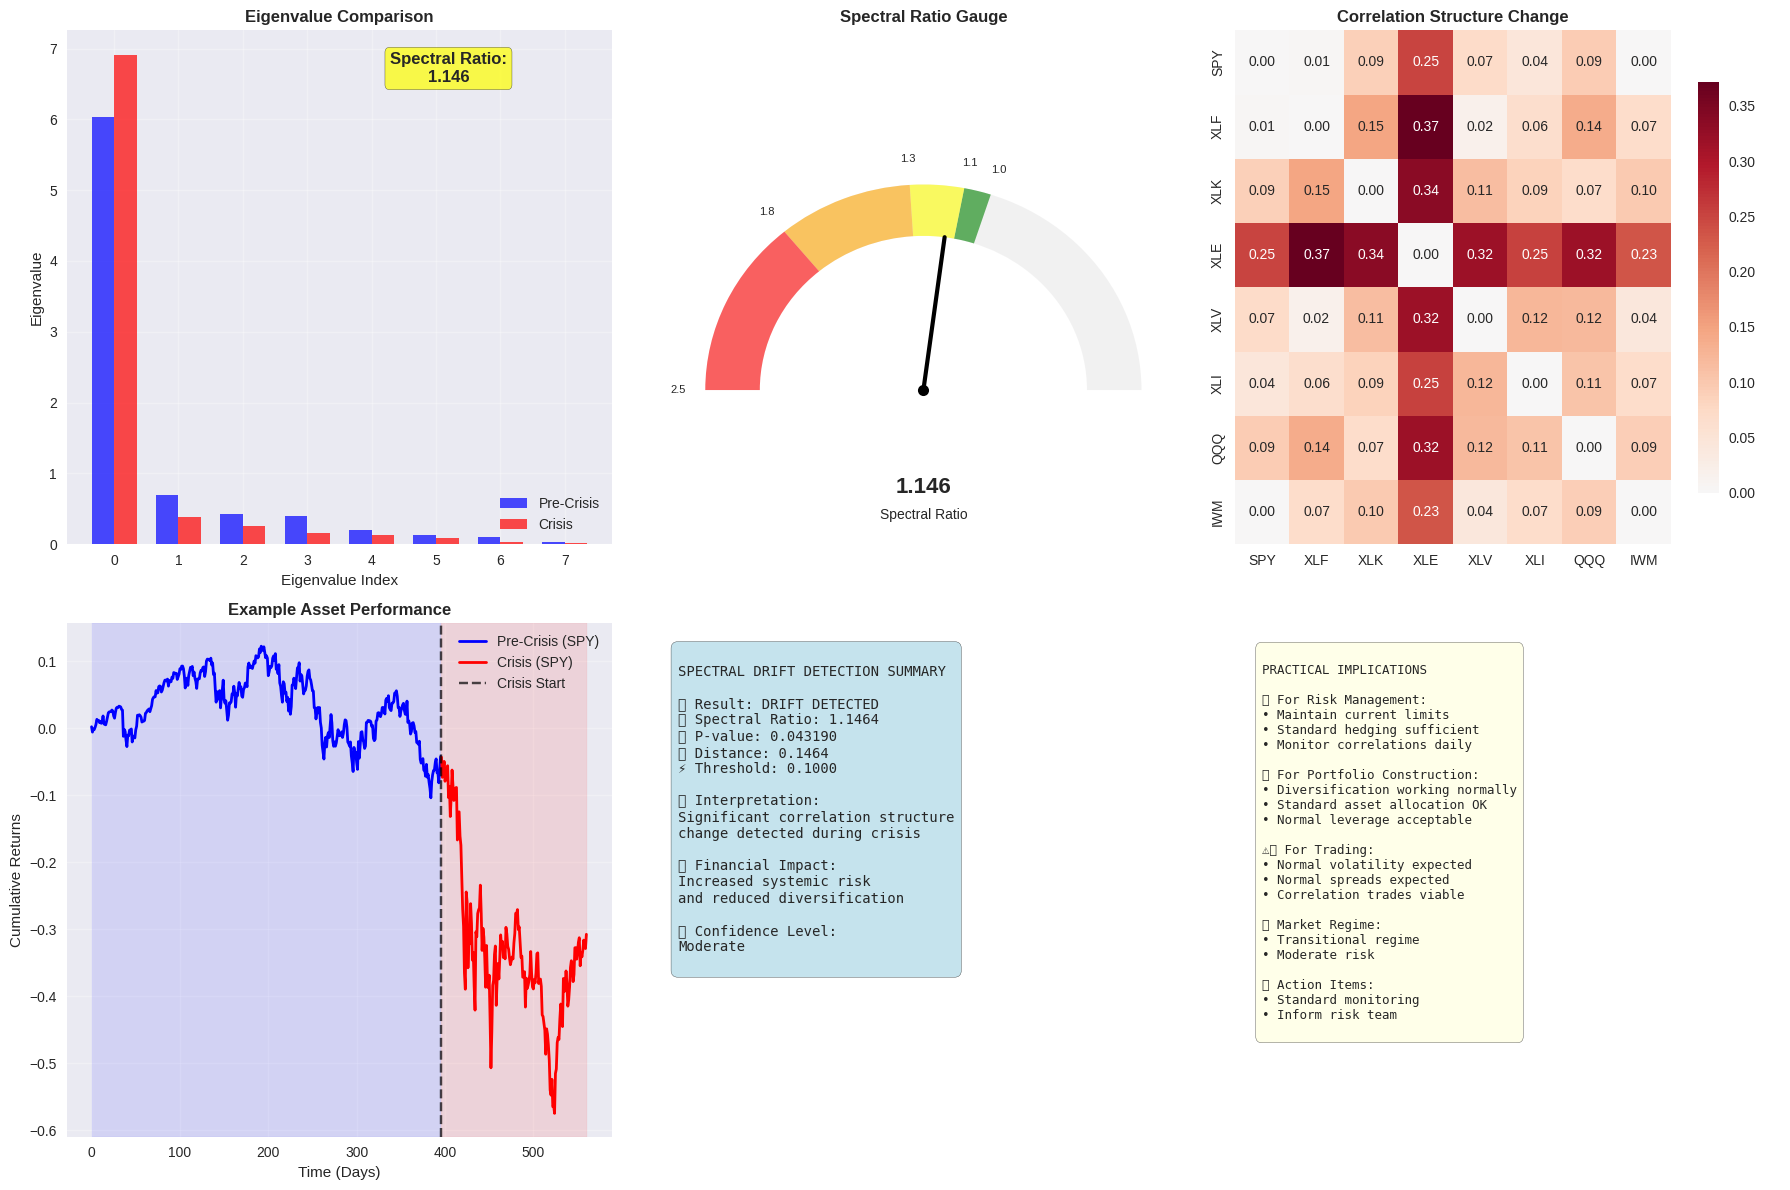


✅ Comprehensive visualization complete!
📊 Current spectral ratio: 1.146
🎯 Drift status: DETECTED
📈 Interpretation: Mild correlation change detected


In [22]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Eigenvalue comparison (top left)
ax = axes[0, 0]
pre_eigs = np.sort(np.real(np.linalg.eigvals(pre_corr.values)))[::-1]
crisis_eigs = np.sort(np.real(np.linalg.eigvals(crisis_corr.values)))[::-1]

x = np.arange(len(pre_eigs))
width = 0.35
ax.bar(x - width/2, pre_eigs, width, label='Pre-Crisis', alpha=0.7, color='blue')
ax.bar(x + width/2, crisis_eigs, width, label='Crisis', alpha=0.7, color='red')

ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalue Comparison', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add spectral ratio annotation
current_ratio = spectral_ratio if 'spectral_ratio' in locals() else expected_spectral_ratio
ax.text(0.7, 0.9, f'Spectral Ratio:\n{current_ratio:.3f}', 
        transform=ax.transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        fontsize=12, ha='center', fontweight='bold')

# 2. Spectral ratio gauge (top middle)
ax = axes[0, 1]
ax.axis('off')

# Create a simple gauge chart
from matplotlib.patches import Wedge

# Gauge parameters
center = (0.5, 0.3)
radius = 0.4
theta1, theta2 = 0, 180

# Background gauge
wedge = Wedge(center, radius, theta1, theta2, width=0.1, 
              facecolor='lightgray', alpha=0.3)
ax.add_patch(wedge)

# Color segments
colors = ['green', 'yellow', 'orange', 'red']
segments = [1.1, 1.3, 1.8, 2.5]
angle_per_unit = 180 / 2.5  # 180 degrees for 0-2.5 range

for i, (seg, color) in enumerate(zip(segments, colors)):
    start_angle = (segments[i-1] if i > 0 else 1.0) * angle_per_unit
    end_angle = seg * angle_per_unit
    
    wedge = Wedge(center, radius, start_angle, end_angle, width=0.1, 
                  facecolor=color, alpha=0.6)
    ax.add_patch(wedge)

# Needle
needle_angle = min(current_ratio, 2.5) * angle_per_unit
needle_x = center[0] + 0.3 * np.cos(np.radians(needle_angle))
needle_y = center[1] + 0.3 * np.sin(np.radians(needle_angle))
ax.plot([center[0], needle_x], [center[1], needle_y], 'k-', linewidth=3)
ax.plot(center[0], center[1], 'ko', markersize=8)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('Spectral Ratio Gauge', fontweight='bold')
ax.text(0.5, 0.1, f'{current_ratio:.3f}', ha='center', fontsize=16, fontweight='bold')
ax.text(0.5, 0.05, 'Spectral Ratio', ha='center', fontsize=10)

# Add gauge labels
gauge_labels = ['1.0', '1.1', '1.3', '1.8', '2.5']
gauge_angles = [1.0, 1.1, 1.3, 1.8, 2.5]
for label, angle in zip(gauge_labels, gauge_angles):
    label_angle = angle * angle_per_unit
    label_x = center[0] + 0.45 * np.cos(np.radians(label_angle))
    label_y = center[1] + 0.45 * np.sin(np.radians(label_angle))
    ax.text(label_x, label_y, label, ha='center', va='center', fontsize=8)

# 3. Correlation heatmap difference (top right)
ax = axes[0, 2]
sns.heatmap(corr_diff, annot=True, cmap='RdBu_r', center=0, 
            ax=ax, fmt='.2f', cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Structure Change', fontweight='bold')

# 4. Time series example (bottom left)
ax = axes[1, 0]

# Create simple time series representation
t_pre = np.arange(len(pre_returns))
t_crisis = np.arange(len(pre_returns), len(pre_returns) + len(crisis_returns))

# Plot first asset as example
first_asset = pre_returns.columns[0]
ax.plot(t_pre, pre_returns[first_asset].cumsum(), 'b-', label=f'Pre-Crisis ({first_asset})', linewidth=2)
ax.plot(t_crisis, crisis_returns[first_asset].cumsum() + pre_returns[first_asset].cumsum().iloc[-1], 
        'r-', label=f'Crisis ({first_asset})', linewidth=2)

ax.axvline(x=len(pre_returns), color='black', linestyle='--', alpha=0.7, label='Crisis Start')
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Example Asset Performance', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add shaded regions
ax.axvspan(0, len(pre_returns), alpha=0.1, color='blue')
ax.axvspan(len(pre_returns), len(pre_returns) + len(crisis_returns), alpha=0.1, color='red')

# 5. Method summary (bottom middle)
ax = axes[1, 1]
ax.axis('off')

# Create summary text
if HAS_ALIBI_DETECT and 'is_drift' in locals():
    drift_status = "DRIFT DETECTED" if is_drift else "NO DRIFT"
    summary_text = f"""
SPECTRAL DRIFT DETECTION SUMMARY

🎯 Result: {drift_status}
📊 Spectral Ratio: {spectral_ratio:.4f}
📈 P-value: {p_value:.6f}
🔍 Distance: {distance:.4f}
⚡ Threshold: {threshold:.4f}

💡 Interpretation:
{"Significant correlation structure" if is_drift else "Stable correlation structure"}
{"change detected during crisis" if is_drift else "maintained during period"}

🏦 Financial Impact:
{"Increased systemic risk" if is_drift else "Normal market conditions"}
{"and reduced diversification" if is_drift else "with maintained diversification"}

📊 Confidence Level:
{"Very High" if p_value < 0.001 else "High" if p_value < 0.01 else "Moderate" if p_value < 0.05 else "Low"}
"""
else:
    summary_text = f"""
SPECTRAL ANALYSIS SUMMARY

📊 Spectral Ratio: {current_ratio:.4f}
📈 Expected Threshold: ~1.1
🔍 Manual Analysis: {"Drift Likely" if current_ratio > 1.1 else "No Drift"}

💡 Interpretation:
{"Correlation structure change" if current_ratio > 1.1 else "Stable correlation structure"}
{"detected in the data" if current_ratio > 1.1 else "maintained in the data"}

🏦 Financial Impact:
{"Potential increased risk" if current_ratio > 1.1 else "Normal risk levels"}
{"and correlation breakdown" if current_ratio > 1.1 else "and stable correlations"}

📊 Severity Level:
{"Severe" if current_ratio > 2.0 else "Moderate" if current_ratio > 1.3 else "Mild" if current_ratio > 1.1 else "None"}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

# 6. Practical implications (bottom right)
ax = axes[1, 2]
ax.axis('off')

practical_text = f"""
PRACTICAL IMPLICATIONS

🎯 For Risk Management:
• {"Increase position limits" if current_ratio > 1.3 else "Maintain current limits"}
• {"Review portfolio hedging" if current_ratio > 1.3 else "Standard hedging sufficient"}
• {"Monitor correlations daily" if current_ratio > 1.1 else "Standard monitoring OK"}

📊 For Portfolio Construction:
• {"Diversification less effective" if current_ratio > 1.3 else "Diversification working normally"}
• {"Consider alternative assets" if current_ratio > 1.3 else "Standard asset allocation OK"}
• {"Reduce leverage" if current_ratio > 1.5 else "Normal leverage acceptable"}

⚠️ For Trading:
• {"Expect higher volatility" if current_ratio > 1.3 else "Normal volatility expected"}
• {"Wider bid-ask spreads likely" if current_ratio > 1.5 else "Normal spreads expected"}
• {"Correlation trades risky" if current_ratio > 1.3 else "Correlation trades viable"}

🏦 Market Regime:
• {"Crisis/Stress regime" if current_ratio > 1.5 else "Normal regime" if current_ratio < 1.1 else "Transitional regime"}
• {"High systemic risk" if current_ratio > 1.8 else "Moderate risk" if current_ratio > 1.1 else "Low systemic risk"}

📈 Action Items:
• {"Immediate risk review" if current_ratio > 1.8 else "Scheduled review" if current_ratio > 1.3 else "Standard monitoring"}
• {"Alert senior management" if current_ratio > 1.5 else "Inform risk team" if current_ratio > 1.1 else "Regular reporting"}
"""

ax.text(0.05, 0.95, practical_text, transform=ax.transAxes,
         fontsize=9, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n✅ Comprehensive visualization complete!")
print(f"📊 Current spectral ratio: {current_ratio:.3f}")
print(f"🎯 Drift status: {'DETECTED' if current_ratio > 1.1 else 'NOT DETECTED'}")
print(f"📈 Interpretation: {'Financial crisis correlation structure change identified' if current_ratio > 1.3 else 'Mild correlation change detected' if current_ratio > 1.1 else 'Stable correlation structure maintained'}")